# IMA 206 - Coding autoencoders in Pytorch

The lab was originally created by Alasdair Newson (https://sites.google.com/site/alasdairnewson/)

The current version is made by Loic Le Folgoc. If you have questions, please contact me at loic dot lefolgoc at telecom-paris dot fr.

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST. We recall that an autoencoder is a neural network with the following general architecture:


![AUTOENCODER](https://drive.google.com/uc?id=11dfNujSHa2-_eThp2aTpL1M_hLaEQX-G)


The tensor $z$ in the middle of the network is called a __latent code__, and it belongs to the latent space. It is this latent space which is interesting in autoencoders (for image synthesis, editing, etc).

## Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE or ...)

First of all, let's load some packages:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
# Fixing seed for reproduciablity
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# Set the seed for reproducibility
set_seed(0)

First, we load the mnist dataset. I find that training on the full training dataset `mnist_trainset` is fast enough even on CPU (5-10 minutes), but should you need it, we create a reduced trainset below.

Feel free to train on `mnist_trainset_reduced` instead if you prefer (results might be of poorer quality). To do so, replace the argument `mnist_trainset` in the `torch.utils.data.DataLoader(...)` call creating `mnist_train_loader` in the cell below by `mnist_trainset_reduced` (and same for `mnist_testset` and `mnist_testset_reduced`).

In [4]:
batch_size = 64

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 5000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)
#mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=batch_size, shuffle=True, drop_last=False)

# download test dataset
max_mnist_size = 1000
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)
#mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=batch_size, shuffle=False, drop_last=False)


In [5]:
mnist_train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

# 1. Vanilla Autoencoder

Now, we define our autoencoder model. The autoencoder class `AEModel` is made of an `Encoder` and a `Decoder`, which we create first. We will reuse the `Encoder` and `Decoder` classes when building our variational autoencoder model, and wrap them in a `VAEModel` instead.

We will use the following convolutional architectures :

__Encoder__ :
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=1; + ReLU
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=0; + ReLU
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=0; + ReLU
- Flatten
- Dense layer with 64 output neurons; + ReLU
- Dense layer with `self.latent_dim*self.multiplier` output neurons.

For the autoencoder, `self.multiplier=1` as the encoder outputs a `self.latent_dim`-dimensional latent code. For the variational autoencoder, we will set `self.multiplier=2` as the encoder will output `self.latent_dim`-dimensional mean and log-variance parameters of the Gaussian distribution $q_\phi(z|x)$.

__Decoder__ (the decoder of the AE and VAE are the same, they always outputs an image/probability map, given a code $z$ as input):
- Dense layer with 64 output neurons; + ReLU
- Dense layer with ??? output neurons; + ReLU
- Reshape, to a `(C, H, W)` tensor with `C=32`, `H=???`, `W=???`.
- Conv transpose layer, 32 filters, 4x4 kernel, stride=2, padding=0; +ReLU
- Conv transpose layer, 32 filters, 4x4 kernel, stride=2, padding=0; +ReLU
- Conv transpose layer, 1 filter, 4x4 kernel, stride=2, padding=1; +Sigmoid

The number of output neurons of the second dense layer is exactly the number of input neurons in the first dense layer of the encoder (i.e., the number of values in the feature maps of the conv layer immediately before it).

For the reshape operations, use the ```A.view(dim_1,dim_2,...)``` function, where ```A``` is your tensor.

__Hint for computing the number of neurons that are not given to you__: This [great resource](https://madebyollin.github.io/convnet-calculator/) lets you compute the size of the output tensor following any convolution layer depending on the input tensor shape and conv parameters.

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim=10, multiplier=1):
        super(Encoder, self).__init__()

        # Layer parameters
        self.latent_dim = latent_dim
        self.multiplier = multiplier

        # Shape at the end of conv3
        self.reshape = (32,2,2)

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=4,stride = 2,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=4,stride = 2,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=4,stride = 2,padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,self.latent_dim*self.multiplier)

        self.activation  = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        '''
        Pass the input image mini-batch through conv, linear layers and
        non-linearities to output a (B,D,multiplier) tensor where B is the mini-batch
        size and D the latent dimension.
        '''
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.activation(out)

        # Flatten
        out = self.flatten(out)

        # Fully connected layer with ReLu activation
        out = self.fc1(out)
        out = self.activation(out)


        # Fully connected layer for code z, or mean and log-variance
        out = self.fc2(out)
        #out = self.activation(out)

        # The shape of the output tensor should be (B,D) if multiplier=1,
        # where B is the batch size, and D the latent dimension.
        # Otherwise it should be (B,D,multiplier)
        if (self.multiplier == 2):
          out = out.view(batch_size,self.latent_dim,self.multiplier)
        return out

In [7]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        # Shape required to start transpose convs (copy paste from the encoder)
        self.reshape = (32,2,2)

        # Fully connected layers
        self.fc1 = nn.Linear(self.latent_dim,64)
        self.fc2 = nn.Linear(64,128)

        # Convolutional layers
        self.convT1 = nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size = 4,stride = 2,padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size = 4,stride = 2,padding=0)
        self.convT3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,kernel_size = 4,stride = 2,padding=1)

        self.activation = nn.ReLU()
        self.final_activation = nn.Sigmoid()
    def forward(self, z):
        batch_size = z.size(0)

        # Fully connected layers with ReLu activations
        out = self.fc1(z)
        out = self.activation(out)

        out = self.fc2(out)
        out = self.activation(out)

        # Reshape
        out = out.view(batch_size,*self.reshape)

        # Convolutional layers with ReLu activations
        out = self.convT1(out)
        out = self.activation(out)
        out = self.convT2(out)
        out = self.activation(out)

        # Final conv layer with sigmoid activation
        out = self.convT3(out)
        out = self.final_activation(out)


        return out

The autoencoder model itself is basically a wrapper around an `Encoder` and a `Decoder`. In the forward pass, the input images contained in the tensor `x` are passed through the `Encoder` to obtain the latent codes `z` then these codes are fed to the `Decoder` to produce the reconstructions `y`.

In [8]:
class AEModel(nn.Module):
    def __init__(self, latent_dim):
        """
        Class which defines model and forward pass.

        Parameters
        ----------
        latent_dim : int
            Dimensionality of latent code.
        """
        super(AEModel, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim = latent_dim,multiplier=1)
        self.decoder = Decoder(latent_dim = latent_dim)

    def forward(self, x, mode='sample'):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)

        Outputs a dictionary containing:
          codes - the latent codes corresponding to the input images
          reconstructions - the images reconstructed by the autoencoder
        """

        # z is the output of the encoder
        z = self.encoder(x)

        # Decode the samples to image space
        y = self.decoder(z)

        # Return everything:
        return {
            'reconstructions': y,
            'codes': z
            }

Next, we carefully create the reconstruction loss. It will be reused for the VAE loss later on.

The reconstruction loss translates a pixel-wise Bernoulli probabilistic model into a loss (`F.binary_cross_entropy`). It takes input images `data` and reconstructed probability maps `reconstructions` and computes the binary cross-entropy, from the two images.

In [9]:
def reconstruction_loss(reconstructions, data):
    """
    Calculates the reconstruction loss for a batch of data. I.e. negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (e.g. batch of images). Shape : (batch_size, 1,
        height, width).

    reconstructions : torch.Tensor
        Reconstructed data. Shape : (batch_size, 1, height, width).

    Returns
    -------
    loss : torch.Tensor
        Binary cross entropy, AVERAGED over images in the batch but SUMMED over
        pixel and channel.
    """
    batch_size, n_chan, height, width = reconstructions.size()

    # The pixel-wise loss is the binary cross-entropy, computed from
    # reconstructions and data. It is summed over pixels and averaged across
    # samples in the batch.
    loss_function = nn.BCELoss(reduction='none')
    loss_pixel_wise = loss_function(reconstructions,data)
    loss_batch_wise = loss_pixel_wise.sum(dim=[1, 2, 3]) # sum over all channels, and pixels
    loss = loss_batch_wise.mean()
    return loss

### Training the vanilla autoencoder

The training proceeds as usual. We instantiate a model, move it to the correct device, create an optimizer and write the training loop.

In [10]:
# Parameters
latent_dim = 10

learning_rate = 1e-3
n_epoch = 5 # if running on GPU you can use more epochs (10 or more)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
# Model
ae_model = AEModel(latent_dim=latent_dim)
ae_model = ae_model.to(device)

In [13]:
# Use the AdamW optimizer, set the correct learning rate and weight_decay to 1e-4
optimizer = optim.Adam(ae_model.parameters(),lr =learning_rate,weight_decay=1e-4)

In [14]:
ae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      data = data.to(device)

      # Pass the input data through the model
      predict = ae_model(data)
      reconstructions = predict['reconstructions']

      # Compute the AE loss
      loss = reconstruction_loss(reconstructions,data)

      # set the gradients back to 0
      optimizer.zero_grad()

      # Backpropagate
      loss.backward()
      # parameter update
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [01:08<00:00, 13.67batch/s, loss=118]


Epoch 0: Train Loss: 177.7462


Epoch 1: 100%|██████████| 938/938 [01:15<00:00, 12.37batch/s, loss=105]


Epoch 1: Train Loss: 109.5765


Epoch 2: 100%|██████████| 938/938 [01:57<00:00,  7.96batch/s, loss=87.4]


Epoch 2: Train Loss: 94.8464


Epoch 3: 100%|██████████| 938/938 [01:19<00:00, 11.86batch/s, loss=101]


Epoch 3: Train Loss: 90.2010


Epoch 4: 100%|██████████| 938/938 [01:14<00:00, 12.62batch/s, loss=85.5]

Epoch 4: Train Loss: 87.8265


### Testing the vanilla autoencoder

We define functions for qualitative testing of the autoencoder model. We will reuse them throughout the lab.

In [15]:
def display_images(imgs):
  '''
  Display a batch of images (typically synthetic/generated images)
  '''
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    # black and white images
    axs[j].imshow(imgs[j, 0,:,:].detach().cpu().numpy(), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs):
  '''
  Display a batch of input images along with their reconstructions by a given model
    First row: input images
    Second row: reconstructed images
  '''
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]

  # get output images
  output_imgs = ae_model(test_imgs.to(ae_model.encoder.conv1.weight.device))['reconstructions']
  output_imgs = output_imgs.detach().cpu().numpy()

  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

Let's see how well the autoencoder reconstructs images from the training set:

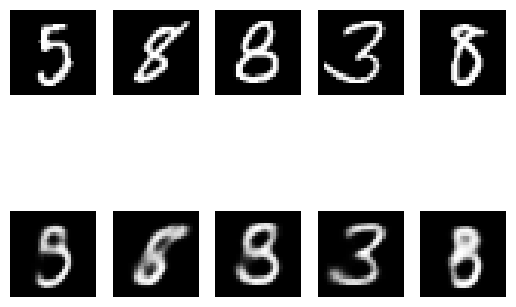

In [16]:
# reconstructing training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(ae_model, train_imgs)

What about images from the test set?

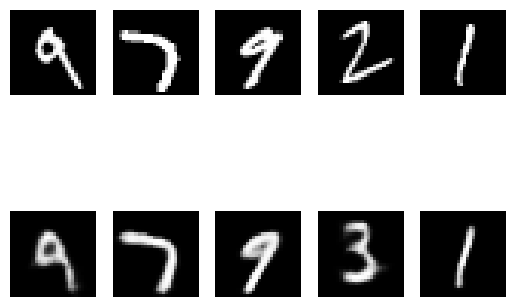

In [17]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae_images(ae_model, test_imgs)

There is not too much overfitting at work here apparently. We can quantify this by computing the reconstruction loss over the test dataset (below) and comparing it to the reconstruction loss over the training dataset at the end of training (check the training cell above).

In [18]:
ae_model.eval()
test_loss=0.0

# We will store all the latent codes corresponding to the test images for reuse
# later on.
zs_test = np.zeros((len(mnist_test_loader.dataset),ae_model.latent_dim))

n = 0
with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    # Put the data on the correct device:
    data = data.to(device)

    # Pass the data through the model
    predict = ae_model(data)
    reconstructions = predict['reconstructions']
    z = predict['codes']

    # Compute the AE loss
    loss =  reconstruction_loss(reconstructions,data)

    # Store quantities of interest
    minibatch_size = z.shape[0]
    zs_test[n:(n+minibatch_size),:] = z.detach().cpu().numpy()

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

    # increment n to fill next parts of the arrays
    n += minibatch_size

print('Test Loss: {:.4f}'.format(test_loss/len(mnist_test_loader)))

100%|██████████| 157/157 [00:08<00:00, 19.15batch/s, loss=77.1]

Test Loss: 85.7155


The test and training average reconstruction losses are indeed similar.

Are you happy with the quality of the __reconstructions__? Next, we will see if this autoencoder model is good at __generating__ images.

The reconstructions seems pretty realistic and overall have the same shape in them. Furthermore, they are not identical pixel-wise which is good since we are sure like this that our model is able to have a good internal representation and is not overfitting

# 2. Image generation with the vanilla autoencoder

Unfortunately, the vanilla autoencoder is not in itself a generative model because it does not define a joint probability distribution of the data and latent codes. We need to come up with roundabout ways to synthetize data based on this model.

In this section, we consider two naïve approaches to creating generative models from the AE. The general idea is the following:

- train an autoencoder
- estimate different statistics (mean, variance) of the data in the latent space
- using these statistics, define a model based on a Gaussian distribution in the latent space
- generate latent codes with this distribution, then decode them back to image space to obtain synthetic images

We will consider these two situations :

- a multivariate Gaussian distribution with __diagonal covariance matrix__ (each latent variable is an independent random variable). This requires the mean and variance in each latent variable;
- a multivariate Gaussian distribution with __non-diagonal covariance matrix__. This requires the mean and covariance matrix of the latent codes.

Obviously, since this is done _a posteriori_ after training the autoencoder, there is nothing which guarantees that the latent codes do indeed follow a Gaussian distribution. Our goal will be to verify that Variational Autoencoders indeed produce better results than such naïve approaches.

### 2.0. Defining and generating random Gaussian latent codes

Let $z$ be a latent code and $D$ the dimension of the latent space (called ``latent_dim`` in the code). We suppose that the $z$'s follow a multivariate Gaussian distribution, written as:

\begin{equation}
z \sim \mathcal{N}\left(
\mu,
\bf{C}
\right),
\end{equation}
where $\mu$ and $\bf{C}$ are the mean vector and covariance matrix of the Gaussian distribution. To define such a generative model, we must therefore determine $\mu$ and $\bf{C}$. Once this is done, we can generate a random Gaussian latent code in the following manner:

\begin{equation}
z = \mu + {\bf{L}} \varepsilon,
\end{equation}
where $\varepsilon$ is a random vector drawn from a multivariate normal distribution ($\mu=0$ and ${\bf{C}} = \text{Id}$), and $\bf{L}$ is output by a Cholesky decomposition of the positive semi-definite covariance matrix. In other words:

\begin{equation}
{\bf{C}} = {\bf{L}}{\bf{L}^T}.
\end{equation}

This gives a simple method of producing a multivariate Gaussian random variable.

### 2.1. A Gaussian model with diagonal covariance

The first naïve model is  defined in this first case as:

- $\bf{\mu}=\left[\mu_0, \mu_1, \cdots, \mu_{d-1}\right]^T$
- $
  \bf{C} = \begin{pmatrix}
\sigma_0^2 & 0 & \cdots & 0 \\
0 & \sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}^2
\end{pmatrix}$

In this situation, therefore, the matrix $\bf{L}$ can be calculated quite simply, as:
- $
  \bf{L} = \begin{pmatrix}
\sigma_0 & 0 & \cdots & 0 \\
0 & \sigma_1 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}
\end{pmatrix}$

We are going to compute the mean and the component-wise standard deviations from a batch of data. For simplicity you are going to use the latent codes `zs_test` corresponding to the test data to estimate these quantities.<br>

It is actually bad practice, and it would be better to estimate them from the training dataset. We do not do so here for convenience because we have already computed `zs_test` above (we have verified above that overfitting was not a problem, so the difference between the two estimates should be minor).

In [19]:
# zs_test is of shape (N,D) where N is the test dataset size and D the latent dimension
# Compute the vector of mean values and the vector of component-wise std's.
z_average = zs_test.mean(axis=0)
z_sigma = zs_test.std(axis=0)

print("Average of latent codes:",z_average)
print("Standard deviation of latent codes:",z_sigma)

Average of latent codes: [  7.22028331  12.95404638  16.52935552  22.84269631   5.09262123
 -17.04702717  -4.57268441 -12.19493944  -2.83901724   7.36044871]
Standard deviation of latent codes: [ 8.73327296 10.01254043  7.38124362  9.86110605  9.55406743  8.42358051
  9.33853395  8.95613394  8.00462011 12.36779669]


Now, in the next cell generate data with this simple generative model using the approach described above. Display these images with the `display_images` function.

__Hint__. You do not actually have to define the matrix $\bf{L}$ in this case, an element-wise multiplication of two (properly chosen) vectors will suffice. To generate multivariate normal random variables you can use the following Pytorch function:

- `torch.randn`

To convert a numpy array to pytorch tensor, use `torch.from_numpy(...).float()`


In [20]:
def generate_images_diagonal_gaussian(ae_model, z_average, z_sigma, n_images = 5):
    # Sample noise from a standard Gaussian distribution
    epsilon = torch.randn(n_images,*z_average.shape,dtype=torch.float32)

    if(type(z_average) !=type(torch.tensor([0]))):
      z_average = torch.tensor(z_average,dtype=torch.float32)

    if(type(z_sigma) !=type(torch.tensor([0]))):
      z_sigma = torch.tensor(z_sigma,dtype=torch.float32)

    # Using epsilon, generate samples from N(mu,C)
    z_generated = (z_average + z_sigma*epsilon).to(torch.float32)
    # Decode back to image space
    imgs_generated = ae_model.decoder(z_generated.to(device))

    return imgs_generated

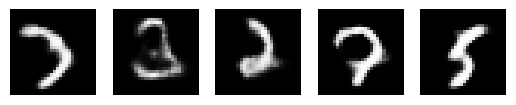

In [21]:
imgs_generated = generate_images_diagonal_gaussian(ae_model, z_average, z_sigma, n_images=5)
display_images(imgs_generated)

What do you think of these samples? Next let's try a slightly more sophisticated model.

This samples seem to be expressing a general idea about what we want to generated. However the digits are not as good as the samples from the training and test set. Thus this leads us to conclude that the latent samples we used are not good enough for this trained model. And that we can still generate better results given a better latent code

### 2.2. Non-diagonal Gaussian model

The second model uses a non-diagonal covariance matrix $\bf{C}$ in the multivariate Gaussian distribution. In the next cell, calculate the mean and covariance matrix from `zs_test`.

__Hint__. You can use the `np.cov` function. Make sure to put the data in the right format for this. Print the shape of z_covariance to verify that you have a matrix of the correct shape (the covariance matrix and not the Gram matrix).

In [22]:
z_average = zs_test.mean(axis=0)
z_covariance = np.cov(zs_test,rowvar=False)

print("\nAverage of latent codes:", z_average)
print("\nShape of Covariance matrix of latent codes:", z_covariance.shape)
print("\nCovariance matrix of latent codes:", z_covariance)


Average of latent codes: [  7.22028331  12.95404638  16.52935552  22.84269631   5.09262123
 -17.04702717  -4.57268441 -12.19493944  -2.83901724   7.36044871]

Shape of Covariance matrix of latent codes: (10, 10)

Covariance matrix of latent codes: [[ 76.27768439 -16.52163543  10.34207311  -8.97914151  12.24050641
  -16.92302578   0.60677847  -5.58144029  21.05290296 -21.46384382]
 [-16.52163543 100.26099187  -6.86048481   9.9384881   -4.08275955
  -18.8488198   -4.12524408  21.98991358  -5.03031618  69.25820476]
 [ 10.34207311  -6.86048481  54.48820623  -3.54283246 -20.68742952
   -1.16490216  -0.55005034  -6.0046447   28.27379729  -2.81367144]
 [ -8.97914151   9.9384881   -3.54283246  97.25113764  -6.47880215
   28.58138448   2.44569343   4.93644139 -35.14242348 -17.51713987]
 [ 12.24050641  -4.08275955 -20.68742952  -6.47880215  91.28933336
  -13.26570531  18.18130689 -28.35707841 -20.14818186 -10.99585046]
 [-16.92302578 -18.8488198   -1.16490216  28.58138448 -13.26570531
   70.963

Now, generate some samples with this distribution. In this case, you actually have to calculate the Cholesky decomposition and find $\bf{L}$. For this, you can use `np.linalg.cholesky`. Then compute the latent codes according to $z = \mu + {\bf{L}} \varepsilon$.

__Hint__. You can use `torch.matmul`. Pay attention to the dimension of `epsilon` to implement it correctly.

In [23]:
# adding epsilon to the covariance matrix to ensure positive definitness
epsilon = 1e-10
z_covariance += epsilon * np.eye(z_covariance.shape[0])
# calculate Cholesky decomposition of covariance matrix : C = L L^T
L = np.linalg.cholesky(z_covariance)
L.shape

(10, 10)

In [24]:
def generate_images_non_diagonal_gaussian(ae_model, z_average, L, n_images = 5):

  # Generate noise according to a standard Gaussian distribution
  epsilon = torch.randn(n_images,*z_average.shape)

  if(type(z_average) !=type(torch.tensor([0]))):
      z_average = torch.tensor(z_average,dtype=torch.float32)

  if(type(L) !=type(torch.tensor([0]))):
      L = torch.tensor(L,dtype=torch.float32)
  # Sample latent codes using epsilon
  z_generated = (z_average + (torch.matmul(L,epsilon.unsqueeze(dim = 2))).squeeze(dim=2)   ).to(torch.float32)

  # Decode back to image space
  imgs_generated = ae_model.decoder(z_generated.to(device))

  return imgs_generated

Generate images using this model now:

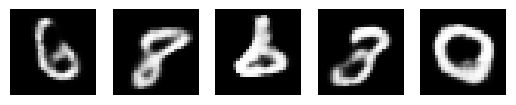

In [25]:
imgs_generated = generate_images_non_diagonal_gaussian(ae_model, z_average, L, n_images = 5)
display_images(imgs_generated)

You should see some improvement, but we can do better than this. Thus, we turn to the variational autoencoder.

# 3. Variational autoencoder

Now, we are going to create a variational autoencoder to carry out __image generation__. Let's first recall the idea of a variational autoencoder.

### Main idea

The main idea is to create an autoencoder whose latent codes follow a certain distribution (a Gaussian distribution in practice). This is done with two tools :

- A specific architecture, where the encoder produces the mean and variance of the latent codes
- A specially designed loss function

Once the VAE is trained, it is possible to sample in the latent space by producing random normal variables and simply decoding.

### Architecture

The architecture of the VAE model is the same as before (using `Encoder` with `multiplier=2` and `Decoder`). However the wrapper `VAEModel` will be a bit more complex as we need to implement the reparametrization trick. We will also implement the code to generate samples (for test time).

### Variational Autoencoder loss

The VAE loss consists in a reconstruction loss and a KL divergence term.

- The reconstruction loss is the same `reconstruction_loss` as before. In other words, the reconstructions are compared to the input images using binary cross-entropy. The reconstructions are generated by sampling a latent code from $q(z|x)$ and decoding it back to image space.

- You will implement the KL divergence term manually below.

In [26]:
class VAEModel(nn.Module):
    def __init__(self, latent_dim):
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim=latent_dim,multiplier = 2)
        self.decoder = Decoder(latent_dim=latent_dim)

    def reparameterize(self, mean, logvar, mode='sample'):
        """
        Samples from a normal distribution using the reparameterization trick.

        Parameters
        ----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)

        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)

        mode : 'sample' or 'mean'
            Returns either a sample from qzx, or just the mean of qzx. The former
            is useful at training time. The latter is useful at inference time as
            the mean is usually used for reconstruction, rather than a sample.
        """
        if mode=='sample':
            # Implements the reparametrization trick (slide 43):
            std = torch.exp(logvar/2)
            eps = torch.randn(*mean.shape)
            eps = eps.to(device)
            return mean + std*eps
        elif mode=='mean':
            return mean
        else:
            return ValueError("Unknown mode: {mode}".format(mode))

    def forward(self, x, mode='sample'):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)

        mode : 'sample' or 'mean'
            Reconstructs using either a sample from qzx or the mean of qzx
        """

        # stats_qzx is the output of the encoder
        stats_qzx = self.encoder(x)

        # Use the reparametrization trick to sample from q(z|x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1), mode=mode)

        # Decode the samples to image space
        reconstructions = self.decoder(samples_qzx)

        # Return everything:
        return {
            'reconstructions': reconstructions,
            'stats_qzx': stats_qzx,
            'samples_qzx': samples_qzx}

    def sample_qzx(self, x):
        """
        Returns a sample z from the latent distribution q(z|x).

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        stats_qzx = self.encoder(x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1))
        return samples_qzx

    def sample_pz(self, N):
        samples_pz = torch.randn(N, self.latent_dim, device=self.encoder.conv1.weight.device)
        return samples_pz

    def generate_samples(self, samples_pz=None, N=None):
        if samples_pz is None:
            if N is None:
                return ValueError("samples_pz and N cannot be set to None at the same time. Specify one of the two.")

            # If samples z are not provided, we sample N samples from the prior
            # p(z)=N(0,Id), using sample_pz
            samples_pz = self.sample_pz(N)

        # Decode the z's to obtain samples in image space (here, probability
        # maps which can later be sampled from or thresholded)
        generations = self.decoder(samples_pz)
        return {'generations': generations}

The KL divergence term is computed as per the regularization term in slide 45 i.e., for each data sample in the mini-batch:
$$\frac{1}{2}\sum_{j=1}^D (\mu_j^2 + \sigma_j^2 - 1 - \log{\sigma_j^2})$$

In [27]:
def kl_normal_loss(mean, logvar):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mean : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    logvar : torch.Tensor
        Diagonal log variance of the normal distribution. Shape (batch_size,
        latent_dim)
    """
    # To be consistent with the reconstruction loss, wetake the mean over the
    # minibatch (i.e., compute for each sample in the minibatch according to
    # the equation above, then take the mean).
    var = torch.exp(logvar)
    latent_kl_batch_wise = 0.5*(mean**2+var-1-logvar).sum(axis=1)
    latent_kl =  latent_kl_batch_wise.mean(axis=0)

    return latent_kl

The `BetaVAELoss` puts it all together as per slide 55.

In [28]:
class BetaVAELoss(object):
    """
    Compute the Beta-VAE loss

    Parameters
    ----------
        beta: (scalar) the weight assigned to the regularization term
    """

    def __init__(self, beta):
        self.beta = beta

    def __call__(self, reconstructions, data, stats_qzx):
        stats_qzx = stats_qzx.unbind(-1)

        # Reconstruction loss
        rec_loss = reconstruction_loss(reconstructions,data)

        # KL loss
        kl_loss = kl_normal_loss(*stats_qzx)

        # Total loss of beta-VAE
        loss = rec_loss + self.beta*kl_loss

        return loss

### Training the Variational Autoencoder

This follows the traditional pipeline that you are by now familiar with.

In [29]:
latent_dim = 10
beta= 1.0

learning_rate = 1e-3
n_epoch = 5 # use the same number of epochs as before for fairness

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
vae_model = VAEModel(latent_dim)
vae_model = vae_model.to(device)

In [32]:
# To keep it simple, we can leave beta at 1.0 for the beta-VAE loss
# Feel free to experiment with it to see different trade-offs between reconstruction
# and generation performance.

vae_loss = BetaVAELoss(beta=beta)

In [33]:
# AdamW, with learning rate set to the parameter above and weight decay to 1e-4
optimizer = optim.Adam(vae_model.parameters(),lr= learning_rate,weight_decay=1e-4)

In [34]:
vae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      data = data.to(device)

      # Pass the input data through the model
      predict = vae_model(data)
      reconstructions = predict['reconstructions']
      stats_qzx = predict['stats_qzx']
      #ep = 1e-12
      #stats_qzx_new= torch.stack([stats_qzx[:,:,0],torch.log(stats_qzx[:,:,1]+ep)] ,dim=2)
      #print(f"this batch has :\n stats_qzx mean = {predict['stats_qzx'][:,:,0].mean(axis=0)} std = {predict['stats_qzx'][:,:,1].mean(axis=0)}")
      # Compute the beta-VAE loss
      loss = vae_loss(reconstructions,data,stats_qzx)
      #print(loss)
      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [00:56<00:00, 16.58batch/s, loss=132]


Epoch 0: Train Loss: 192.0851


Epoch 1: 100%|██████████| 938/938 [01:09<00:00, 13.46batch/s, loss=120]


Epoch 1: Train Loss: 131.7242


Epoch 2: 100%|██████████| 938/938 [02:25<00:00,  6.45batch/s, loss=138]


Epoch 2: Train Loss: 120.7728


Epoch 3: 100%|██████████| 938/938 [02:56<00:00,  5.30batch/s, loss=117]


Epoch 3: Train Loss: 116.9169


Epoch 4: 100%|██████████| 938/938 [02:47<00:00,  5.60batch/s, loss=120]

Epoch 4: Train Loss: 114.7118


### Testing the VAE model

Let's check how well the VAE reconstructs training samples:

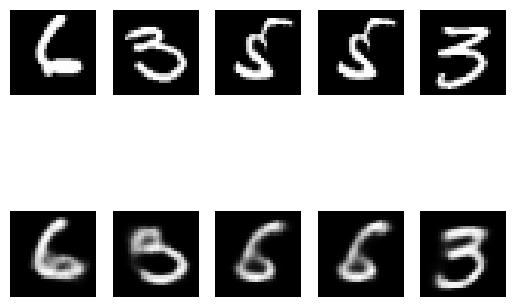

In [35]:
# reconstructing training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(vae_model, train_imgs)

Same for test samples:

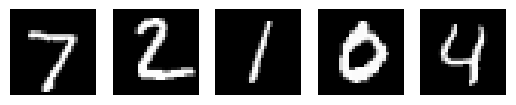

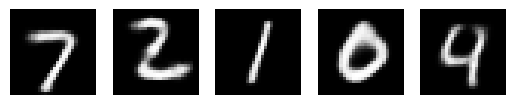

In [36]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0][:5]
#display_ae_images(vae_model, test_imgs)
reconstructed_images = vae_model(test_imgs,mode="mean")['reconstructions']
display_images(test_imgs)
display_images(reconstructed_images)

Let's compute the quantitative `reconstruction_loss` on the test data:

In [37]:
vae_model.eval()
test_loss=0.0

# We will store all the latent codes corresponding to the test images for reuse
# later on.
zs_test = np.zeros((len(mnist_test_loader.dataset),vae_model.latent_dim))

n = 0
with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    # Put the data on the correct device:
    data = data.to(device)

    # Pass the data through the model
    predict = vae_model(data,mode="mean")
    reconstructions = predict['reconstructions']
    z = predict['samples_qzx']

    # Compute the AE loss
    loss =  reconstruction_loss(reconstructions,data)

    # Store quantities of interest
    minibatch_size = z.shape[0]
    zs_test[n:(n+minibatch_size),:] = z.detach().cpu().numpy()

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

    # increment n to fill next parts of the arrays
    n += minibatch_size

print('Test Loss: {:.4f}'.format(test_loss/len(mnist_test_loader)))

100%|██████████| 157/157 [00:17<00:00,  8.86batch/s, loss=90.9]

Test Loss: 94.3778


### Image generation with the VAE model

Now, generate some images with the VAE model. You can directly use the `generate_samples` routine from the `VAEModel` class above.

In [56]:
zs_test.mean(axis=0)

array([ 0.03380275,  0.04040245,  0.06462632,  0.04285639, -0.03090221,
        0.09175596,  0.02273956, -0.01000646,  0.04701268, -0.0005183 ])

In [55]:
zs_test.std(axis=0)

array([1.01070572, 0.11157047, 0.96210415, 1.02572296, 1.01941459,
       0.95808446, 0.94230096, 0.97524621, 0.07436101, 1.00336355])

In [38]:
def generate_images_vae(vae_model, n_images=5):
    return vae_model.generate_samples(N=n_images)['generations']

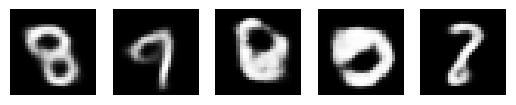

In [39]:
imgs_generated = vae_model.generate_samples(N=5)['generations']
display_images(imgs_generated)

As we can see, using only the z generated from a standard normal random multivariate  distribution is yields acceptable results

Do you think the results are better ? What advantage does the Variational Autoencoder have over the simple autoencoder model, even though the second (non-diagonal Gaussian model) AE approach has a more complex probabilistic latent model (a full covariance matrix)?

Yes, I think that overall the results of the VAE are better. The reconstructions seems visually to be having approximatly the same performance in the two variants of auto-encoders. However the generation step seems to be more effiecent in VAE yielding more realistic images. Bearing in mind that we know the prior p(z) for the vae we are more efficient in generating the samples. Thus the VAE presentes a huge advantage. Further more, the beat-VAE is much more flexibale. Since we can tune the parameter beta so we either focus on the reconstruction or rather on the generation. And in our case including the prior distribution of the latent space in the model allows us to get a much better approximation of the true distibution that the encoder is learning to yield. This is much more better than imposing nothing at all and then supposing a non-diagonal Gaussian model for it.

Next, we compare the models quantitavely.

# 4. Evaluating and comparing the models for image generation

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Nowadays, the standard metric to evaluate the generative performance of a model is the FID (Fréchet Inception Distance). I leave it for you as optional homework to implement it if you wish to do so.

Here, we will follow another path, a simplified version of the Inception Score (IS) that has been somewhat superseded by the FID:

- we train a simple convolutional neural network classifier on MNIST, to a good accuracy
- we generate images with each model
- we find the average of the highest probability of the images according to the classifier, for each model. If this value is high, it means that on average the classifier considers that the images looks like a real image of an actual digit

We will use the following simple convolutional architecture for the classifier:

- conv2d, 3x3 kernel, 32 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- conv2d, 3x3 kernel, 64 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- conv2d, 3x3 kernel, 128 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- Global Average Pooling
- Flatten
- Dense layer

Now, define the model. To make things easier, we use the `torch.nn.Sequential` API to implement the model (there is no need for a Class in this simple case).

__Hint__. For the global average pooling, use the `torch.nn.AvgPool2d` layer with the suitable kernel size and stride.

In [41]:
nb_classes = 10
kernel_size = (3, 3)

mnist_classification_model = torch.nn.Sequential(
        nn.Conv2d(1,32,3,2,1),nn.ReLU(),nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,2,1),nn.ReLU(),nn.BatchNorm2d(64),
        nn.Conv2d(64,128,3,2,1),nn.ReLU(),nn.BatchNorm2d(128),
        nn.AvgPool2d(4),
        nn.Flatten(),
        nn.Linear(128,10)
    )

mnist_classification_model = mnist_classification_model.to(device)

In [42]:
learning_rate = 1e-2
n_epoch = 5

In [43]:
# Cross entropy with reduction='sum'
criterion = nn.CrossEntropyLoss(reduction='sum')

In [44]:
# AdamW, weight decay set to 1e-4
optimizer = optim.Adam(mnist_classification_model.parameters(),lr=learning_rate,weight_decay =1e-4)

In [45]:
input = torch.randn(2,1,28,28)
out = mnist_classification_model(input)
out.shape

torch.Size([2, 10])

In [46]:
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

In [47]:
def cnn_accuracy(x_pred,x_label):
  acc = (x_pred == x_label).sum()/(x_pred.shape[0])
  return acc

In [48]:
imgs,labels =next(iter(mnist_train_loader))
print(f"labels.shape {labels.shape}, imgs.shape{imgs.shape}")

labels.shape torch.Size([64]), imgs.shapetorch.Size([64, 1, 28, 28])


In [49]:
mnist_classification_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
    for imgs, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device
      imgs = imgs.to(device)
      labels = labels.to(device)

      # forward pass and loss computation
      predict= mnist_classification_model(imgs)
      loss= criterion(predict,labels)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute the train loss
      train_loss += loss.item()

      # store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend(vector_to_class(predict).tolist())

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/len(mnist_train_loader.dataset),
                                                            cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

Epoch 0: 100%|██████████| 938/938 [00:50<00:00, 18.59batch/s, loss=0.751]


Epoch:0 Train Loss:0.1668 Accuracy:0.9484


Epoch 1: 100%|██████████| 938/938 [00:50<00:00, 18.48batch/s, loss=0.747]


Epoch:1 Train Loss:0.0618 Accuracy:0.9802


Epoch 2: 100%|██████████| 938/938 [00:51<00:00, 18.16batch/s, loss=0.432]


Epoch:2 Train Loss:0.0486 Accuracy:0.9847


Epoch 3: 100%|██████████| 938/938 [00:52<00:00, 17.84batch/s, loss=1.1]


Epoch:3 Train Loss:0.0397 Accuracy:0.9869


Epoch 4: 100%|██████████| 938/938 [00:51<00:00, 18.32batch/s, loss=0.753]

Epoch:4 Train Loss:0.0364 Accuracy:0.9883


In [50]:
mnist_classification_model.eval()

all_predicted = []
all_labels = []

with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=mnist_classification_model(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = cnn_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:02<00:00, 55.20batch/s]


Test Accuracy: 0.9821


### Evaluate the average maximum prediction of the images generated by each generative model (higher is better)

Now, we evaluate the models. For each ones, produce a certain number of images, and put those images through the classification network. Then find the maximum class probability of each image, and average it over all the images. We will use this as a metric to evaluate each model.

__CAREFUL__: the output of the network does __not__ include the Softmax layer, so you will have to carry it out, with:
- ```torch.nn.Softmax()(...)```

Define this metric now:

In [51]:
def generative_model_score(imgs_in,classification_model):
    logits =classification_model(imgs_in)
    probabilties = torch.nn.Softmax(dim=1)(logits)
    highest_probabilty_per_image = probabilties.max(axis=1)[0]
    gen_score = highest_probabilty_per_image.mean()
    return gen_score

Now, generate some images with each of the three models, and evaluate these models:

In [52]:
imgs_diagonal_gaussian = generate_images_diagonal_gaussian(ae_model,z_average,z_sigma,n_images = 2000)
imgs_non_diagonal_gaussian = generate_images_non_diagonal_gaussian(ae_model,z_average,L,n_images = 2000)
imgs_vae = generate_images_vae(vae_model,n_images=2000)

# average of maximum of first model
diagonal_gaussian_score = float(generative_model_score(imgs_diagonal_gaussian,mnist_classification_model))
non_diagonal_gaussian_score = float(generative_model_score(imgs_non_diagonal_gaussian,mnist_classification_model))
vae_gaussian_score = float(generative_model_score(imgs_vae,mnist_classification_model))

print("Diagonal gaussian generative model score : ",diagonal_gaussian_score)
print("Non diagonal gaussian generative model score : ",non_diagonal_gaussian_score)
print("Variational autoencoder model score: ",vae_gaussian_score)

Diagonal gaussian generative model score :  0.8685743808746338
Non diagonal gaussian generative model score :  0.8900420069694519
Variational autoencoder model score:  0.9060139060020447


Questions:

- Which model is better quantitatively ? (unfortunately there is some variability, even with 2000 samples; you might want to rerun the cell several times to get the trend)
- Do the quantitative result support the qualitative results ?
- Can you see any drawbacks of this method of evaluation ?
- Can you propose any more sophisticated models than the multivariate Gaussian approach (apart from the variational autoencoder) ?

Quantitavely the best model is the Variational autoencoder model yielding 0.906 fllowing it the Non diagonal gaussian generative model then the diagonal gaussian. This indicates that the quantitave results support the qualitative ones.

This methods does suffer from two drawbacks. First the classifier Bias issue : Since the evaluation is highly dependent on the performance and biases of the pre-trained classifier. If the classifier is not robust, it might misrepresent the quality of generated images.

Secondly, mode Collapse: This metric might not effectively capture the diversity of generated images. A model might generate similar images with high confidence scores, leading to misleadingly high scores.

Other ideas might include Generative Adversarial Networks (GANs): GANs are powerful generative models that often produce high-quality images by training a generator and a discriminator in a competitive setting and where we don't need labeled data.
Or we might use Diffusion models which have proven to be very performant in generating new realistic images. They work by modeling the distribution of the data as a gradual denoising process, starting from pure noise and progressively refining it into a coherent image.